In [281]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 

import itertools

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

from tslearn.metrics import dtw as time_warping

import ordpy

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Functions' definitions

In [2]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [92]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [3]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

# Disks

<p style="font-size=200px;"><b>Classification:</b></p>

1) Tumbling

2) Chaotic

3) Steady or periodic behavior</p>

In [6]:
disk_human_class = scipy.io.loadmat('classification/humanClassificationCircle.mat')['behaviourHuman'][0]
disk_feat_class  = scipy.io.loadmat('classification/dataCircleClassified.mat')

In [164]:
# for i, j, k in zip(mat2['dx'], mat2['dy'], range(len(mat2['dy']))):
#     if k in np.argwhere(mat2['behaviourAuto'][0]==3).flatten():
#         print('\n', i, j, k, "###############################", '\n')
#     else:
#         print('not steady', i, j)

In [4]:
#Improving data structure. Extracting data from dataCircle.mat and loading it into data arrays
disk_data = scipy.io.loadmat('classification/dataCircle.mat')

#initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
disk_initcons = []
for i in range(len(disk_data['data'][0])):
    disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
disk_initcons = np.asarray(disk_initcons)

# radii of the disks dropped
disk_radii = []
for i in range(len(disk_data['data'][0])):
    disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
disk_radii = np.asarray(disk_radii)

# camera 1 observable area?
disk_cam1 = []
for i in range(len(disk_data['data'][0])):
    disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
disk_cam1 = np.asarray(disk_cam1)

# camera 2 observable area?
disk_cam2 = []
for i in range(len(disk_data['data'][0])):
    disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
disk_cam2 = np.asarray(disk_cam2)

# coordinates (x, y, z) along trajectory from 1m high to the floor.
disk_trajectories = []
for i in range(len(disk_data['data'][0])):
    disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
disk_trajectories = np.asarray(disk_trajectories)

In [280]:
# a = disk_human_class[disk_human_class!=3]==disk_feat_class['behaviourAuto'][disk_feat_class['behaviourAuto']!=3]

# for a_, i_ in zip(a, range(len(a))):
#     if a_==False:
#         print(i_)

In [278]:
for i in range(clean_disk_cam1.__len__()):
    f, ax = plt.subplots()
    if disk_human_class[i]==1:
        ax.plot(normalize(clean_disk_cam1[i].flatten()), label='Tumbling', color='lawngreen')
    if disk_human_class[i]==2:
        ax.plot(normalize(clean_disk_cam1[i].flatten()), label='Chaotic', color='blue')
    ax.set_ylabel("Relative area Cam1")
    ax.legend(frameon=True)
    
    f.tight_layout()
    f.savefig('figures/{}.svg'.format(i), bbox_inches='tight')
    plt.close()

## data cleaning

In [137]:
clean_disk_trajectories = []
clean_disk_initcons     = []
clean_disk_class        = []
clean_disk_radii        = []
clean_disk_cam2         = []
clean_disk_cam1         = []

for i in range(len(disk_trajectories)):
    #vertical trajectory
    z                = disk_trajectories[i][::,2]
    # removing the last 5 centimeters of the fall.
    trajectory       = disk_trajectories[i][z>.05]
    
    #removing from area series, the last 5cm of the fall
    cut_5pc   = len(z)-len(z[z>.05])
    area_cam2 = disk_cam2[i][:-cut_5pc]
    area_cam1 = disk_cam1[i][:-cut_5pc]

#(original comment) Segment steady and periodic behaviours from trajectories. 
#We only see steady and periodic from horizontal initial condition.
    if disk_initcons[i]==0:        
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<.2*disk_radii[i]
        steady_index       = boolean_trajectory.tolist().index(False)

        if steady_index>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
            pass
#             print(steady_index)
#             clean_disk_trajectories.append(trajectory[:steady_index])
#             clean_disk_initcons.append(0)
#             clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(3)
#             clean_disk_cam1.append(area_cam1[:steady_index])
#             clean_disk_cam2.append(area_cam2[:steady_index])
            
            if len(trajectory[steady_index:])>10: #second part of the sliced original trajectory.
                clean_disk_trajectories.append(trajectory[steady_index:])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[steady_index:])
                clean_disk_cam2.append(area_cam2[steady_index:])
                
                
            else: pass
        
        else: #no segmentation; only one behavior through the whole fall
            clean_disk_trajectories.append(trajectory[steady_index:])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
            clean_disk_cam1.append(area_cam1[steady_index:])
            clean_disk_cam2.append(area_cam2[steady_index:])
                
    else: #no trajectory segmentation
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<0.01
        cut_index          = boolean_trajectory.tolist().index(False)
        
        if len(trajectory[cut_index:])>10: #second part of the sliced original trajectory.
            clean_disk_trajectories.append(trajectory[cut_index:])
            clean_disk_initcons.append(1)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
            clean_disk_cam1.append(area_cam1[cut_index:])
            clean_disk_cam2.append(area_cam2[cut_index:])

# np.save('pickles/clean_disk_trajectories.npy', clean_disk_trajectories)
# np.save('pickles/clean_disk_initcons.npy', clean_disk_initcons)    
# np.save('pickles/clean_disk_class.npy', clean_disk_class)       
# np.save('pickles/clean_disk_radii.npy', clean_disk_radii)       
# np.save('pickles/clean_disk_class.npy', clean_disk_class)       

In [277]:
sum(disk_human_class[disk_human_class!=3]==2)/170

0.5058823529411764

Text(0.5, 0, 'x, lateral')

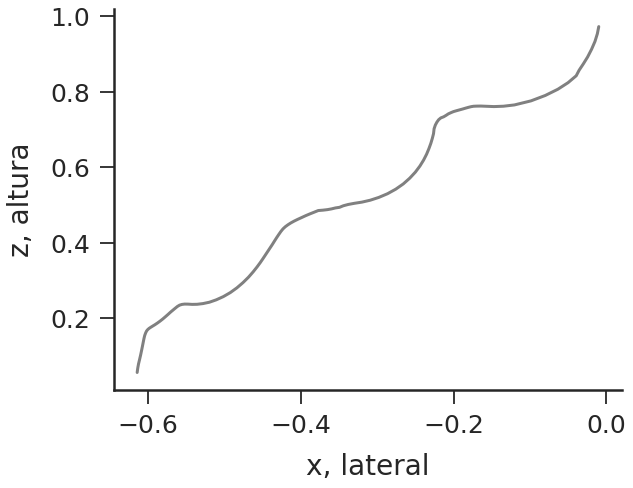

In [273]:
f, ax = plt.subplots()

i      = 9
x_, z_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]

ax.plot(x_, z_, '-', color='grey')
ax.set_ylabel('z, altura')
ax.set_xlabel('x, lateral')

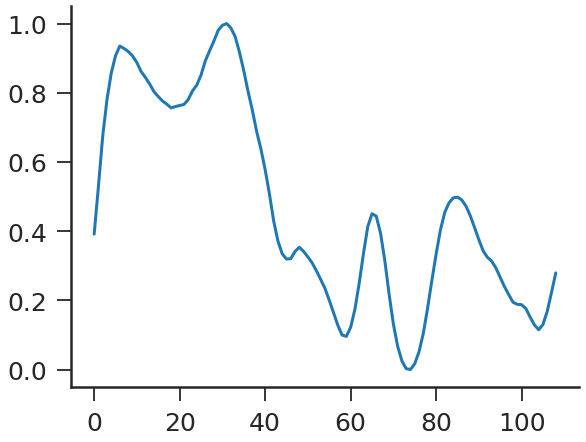

In [65]:
ts = normalize(clean_disk_cam1[101].flatten())
plt.plot(ts)

In [31]:
disk_ce = []
for ts in disk_cam1:
    ts = normalize(ts.flatten())
    disk_ce.append(ordpy.complexity_entropy(ts, dx=2))

In [61]:
disk_ce = []
for i, class_ in zip(range(len(clean_disk_cam1)), clean_disk_class):
    if not class_==3:
        ts = clean_disk_cam1[i]
        disk_ce.append(ordpy.complexity_entropy(ts, dx=4))
    else:
        pass

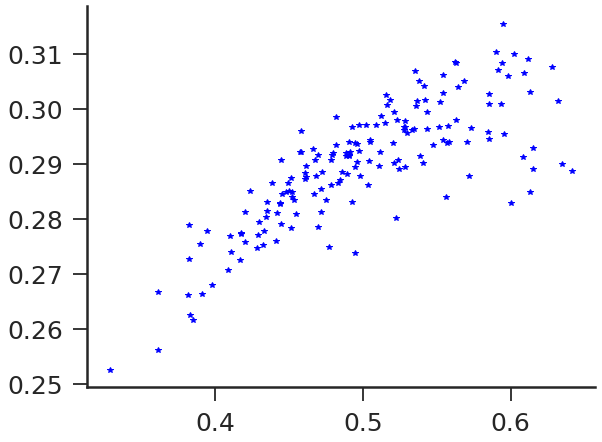

In [62]:
for h_, c_ in disk_ce:
    plt.plot(h_,c_, '.', marker='*', color='blue')

In [184]:
disk_ce = []
for i, class_ in zip(range(len(clean_disk_trajectories)), clean_disk_class):
    if not class_==3:
        ts = clean_disk_trajectories[i][::,2]
        disk_ce.append(ordpy.complexity_entropy(ts, dx=4))
    else:
        pass

In [180]:
disk_human_class.__len__()

218

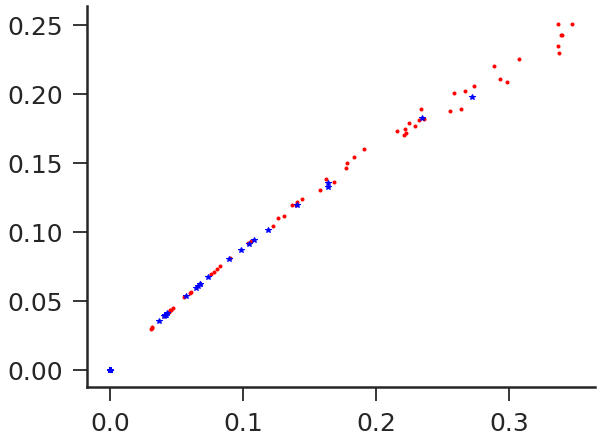

In [185]:
a = disk_human_class
a = a[a!=3]

for (h_, c_), class_ in zip(disk_ce, a):
    if class_==1:
        plt.plot(h_,c_, '.', marker='*', color='blue')
    else:
        plt.plot(h_,c_, '.', color='red', zorder=0)

In [256]:
# 21seconds to run.
dtw_matrix = []
ts         = clean_disk_trajectories
A          = range(ts.__len__())

for i,j in list(itertools.product(A, A)):
    ts1 = scipy.stats.zscore(ts[i][::,0::2], axis=0)
    ts2 = scipy.stats.zscore(ts[j][::,0::2], axis=0)
    dtw_matrix.append(time_warping(ts1, ts2))

In [257]:
dtw_matrix_shape = np.reshape(dtw_matrix, (170,-1))

In [259]:
X = dtw_matrix_shape
# X = np.stack((X, X), axis=2)
for n_clusters in range(2, 10):
    model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='discretize', n_jobs=-1)
    model.fit(X)
    labels = model.labels_
    print(silhouette_score(X, labels, metric='precomputed'))

0.07703691655040977
0.01485333623516585
-0.03978829338035099
-0.10822821517706804
-0.1210941606318652
-0.11572329713410195
-0.12733568680194327
-0.15376645724493493


In [261]:
X = dtw_matrix_shape
model = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='discretize', n_jobs=-1)
model.fit(X)
labels = model.labels_
print(silhouette_score(X, labels, metric='precomputed'))

0.07703691655040977


In [262]:
labels

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [40]:
disk_human_class[disk_human_class!=3]

array([1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2], dtype=uint8)

In [249]:
sum(disk_human_class[disk_human_class!=3]==np.where(labels==0, 2, labels))/170

0.6176470588235294

In [263]:
sum(disk_human_class[disk_human_class!=3]==labels+1)/170

0.6235294117647059

In [185]:
sum(disk_feat_class['behaviourAuto'][disk_feat_class['behaviourAuto']!=3]==labels+1)/170

0.5705882352941176

In [239]:
sum(disk_feat_class['behaviourAuto'][disk_feat_class['behaviourAuto']!=3]==np.where(labels==0, 2, labels))/170

0.5235294117647059

In [60]:
disk_human_class[disk_human_class!=3]

array([1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2], dtype=uint8)

In [59]:
labels

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [183]:
B = disk_feat_class['behaviourAuto'][disk_feat_class['behaviourAuto']!=3]

Falta dar um jeito de ler o código do cara e entender o critério dele pra separar um trajetória em duas, no caso, em uma parcela de
trajetória estacionária (periódica) e outro tipo (caótica ou "tumbling").

In [150]:
mat = scipy.io.loadmat('classification/Field1997_data.mat')

In [165]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun 12 09:44:01 2019',
 '__version__': '1.0',
 '__globals__': [],
 'c': array([[2.38277644e+01, 3.89184311e-03, 1.00000000e+00],
        [3.36187395e+01, 3.89184311e-03, 1.00000000e+00],
        [2.40504822e+01, 4.83471860e-03, 1.00000000e+00],
        [3.62164057e+01, 4.83471860e-03, 1.00000000e+00],
        [3.65549199e+01, 5.12939850e-03, 1.00000000e+00],
        [4.12545834e+01, 5.38863962e-03, 1.00000000e+00],
        [4.69936378e+01, 5.23156373e-03, 1.00000000e+00],
        [7.20944119e+01, 3.89184311e-03, 1.00000000e+00],
        [6.63036129e+01, 4.60212597e-03, 1.00000000e+00],
        [7.20944119e+01, 4.97987935e-03, 1.00000000e+00],
        [7.34484412e+01, 5.49596830e-03, 1.00000000e+00],
        [5.92995386e+01, 5.44203937e-03, 1.00000000e+00],
        [6.88175415e+01, 5.33576384e-03, 1.00000000e+00],
        [2.71425194e+01, 6.56341608e-03, 1.00000000e+00],
        [4.08725483e+01, 6.62845751e-03, 1.00

# Hexagons

# Squares

# Crosses